# Deep Learning approach

In [1]:
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

from tqdm import tqdm
import numpy as np

# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

from IPython.display import display
display(device)

import sys
sys.path.append('../src')
from utils import *
from nn_training import *
from architecture import *
sys.path.remove('../src')

device(type='cpu')

In [2]:
df_samples = pd.read_csv('../data/data.csv', index_col='Unnamed: 0')
display(df_samples.head(4))

df_targets = pd.read_csv('../data/target_train.csv')
df_targets['labels'] = df_targets['target'].apply(lambda x: 0 if x == 'OD' else 1)
display(df_targets)

,id,time,ch0,ch1,ch2
0,1_1,0,372.271894,350.219643,408.527289
1,1_1,1,373.393195,349.845876,411.143658
2,1_1,2,371.898127,350.219643,412.638726
3,1_1,3,371.898127,350.967177,413.386260


,id,target,labels
0,111_1,OD,0
1,103_1,OD,0
2,34_2,ID,1
3,78_1,OD,0
4,71_2,OD,0
...,...,...,...
95,136_1,OD,0
96,183_1,ID,1
97,26_2,OD,0
98,6_2,OD,0


In [3]:
X, y =[], []
for id in tqdm(df_targets['id']):
    sample = np.vstack([df_samples[df_samples['id'] == id]['ch0'].to_numpy(),
                        df_samples[df_samples['id'] == id]['ch1'].to_numpy(),
                        df_samples[df_samples['id'] == id]['ch2'].to_numpy()])
    target = df_targets[df_targets['id']==id]['labels']
    X.append(sample)
    y.append(target)
X = np.array(X)
y = np.array(y)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


In [4]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
print(f'The train size: {len(x_train)}',
      f'\nThe val size: {len(x_val)}',
     f'\nThe test size: {len(x_test)}')

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

The train size: 80 
The val size: 10 
The test size: 10


In [5]:
g = torch.Generator()
g.manual_seed(42)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=8, pin_memory=True,  generator=g)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=8, pin_memory=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                        num_workers=8, pin_memory=True, generator=g)

# MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2400*3, 5000),
            nn.BatchNorm1d(5000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(5000, 5000),
            nn.BatchNorm1d(5000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(5000, num_classes),
        )
        
    def forward(self, x):
        return self.layers(x)

In [7]:
model = MLP(num_classes=1).to(device)

In [8]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lr = 3e-4
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)
num_epochs = 100
scheduler = None

model, logs = train(model, opt, criterion, train_loader, val_loader, scheduler = scheduler, 
             path='../models/',
             name='MLP.pth',
             num_epochs=num_epochs,
            device = device, early_stop = 100)


epoch: 23, train_loss: 0.0014529782444393884, val_loss 1.7147845722269266:  24%|██▍       | 24/100 [00:28<02:28,  1.96s/it]Exception ignored in: <function _releaseLock at 0x7fe41babbca0>
Traceback (most recent call last):
  File "/home/d_sherki/anaconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function Socket.__del__ at 0x7fe41a24d3a0>
Traceback (most recent call last):
  File "/home/d_sherki/anaconda3/lib/python3.9/site-packages/zmq/sugar/socket.py", line 178, in __del__
    def __del__(self):
KeyboardInterrupt: 
IOStream.flush timed out
epoch: 77, train_loss: 0.09216330821315448, val_loss 4.497548583512251:  78%|███████▊  | 78/100 [01:24<00:18,  1.19it/s]    

: 

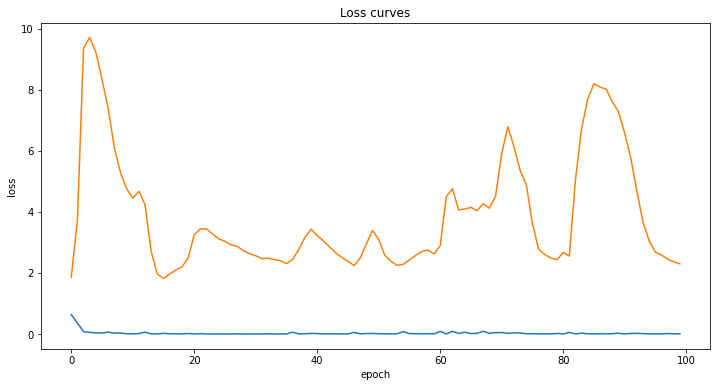

In [ ]:
visualize_log(logs)

In [ ]:
test(model, test_loader, device)

tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')


/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/a

0.0

# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=2400, hidden_size=1000, num_layers=5, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [ ]:
model = LSTM().to(device)

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)
num_epochs = 100
scheduler = None

model, logs = train(model, opt, criterion, train_loader, val_loader, scheduler = scheduler, 
             path='../models/',
             name='LSTM.pth',
             num_epochs=num_epochs,
            device = device, early_stop = 100)

epoch: 99, train_loss: 0.6945995489756266, val_loss 0.6940562665462494: 100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


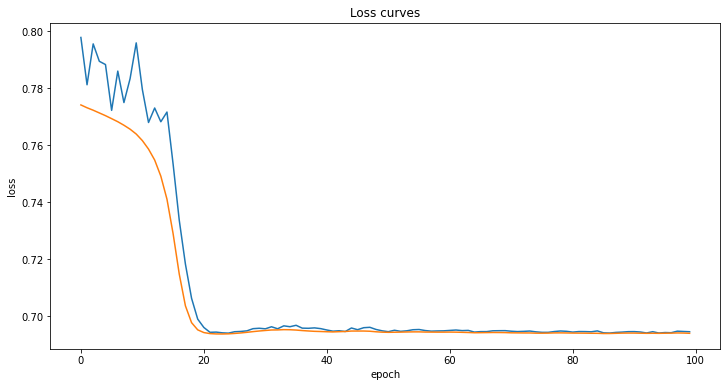

In [ ]:
visualize_log(logs)

In [ ]:
def testing(model, test_loader, device):
        f1s = []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                sample, target = batch
                sample, target = sample.to(device, torch.float), target.to(device, torch.float)
                pred = model(sample)
                pred = torch.argmax(pred,1)
                f1 = f1_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())
                print(target.detach().cpu().numpy(),'\n', pred.detach().cpu().numpy())
                f1s.append(f1)
        return np.mean(f1s)

In [ ]:
test(model, test_loader, device)

tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[0.]], device='cuda:1') 
 tensor([0], device='cuda:1')
tensor([[1.]], device='cuda:1') 
 tensor([0], device='cuda:1')


/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/a

0.0

In [9]:
# Define the ViT model
# model = ViT(img_size=(3, 2500),
#             patch_size=3,
#             in_chans=1,
#             num_classes=2,
#             embed_dim=16,
#             num_heads=4,
#             depth=6,
#             mlp_ratio=2,
#             norm_layer=nn.LayerNorm,
#             act_layer=nn.GELU).to(device)

In [ ]:
del model

In [7]:
x, y = next(iter(train_loader))

In [8]:
x.shape, y.shape

(torch.Size([32, 3, 2400]), torch.Size([32, 1]))

In [11]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, num_channels, seq_length, num_classes):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(16 * (seq_length // 2), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_channels = 3
seq_length = 2400
num_classes = 1

# Создание модели
model = TimeSeriesCNN(num_channels, seq_length, num_classes)

In [22]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_tensor = torch.full((input.size(0),), self.alpha, dtype=torch.float32, device=input.device)
            focal_loss = focal_loss * alpha_tensor
        
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

criterion = FocalLoss(gamma=2, alpha=0.5)  # Initialize Focal Loss with gamma and alpha

In [23]:
# # Define hyperparameters
# input_dim = 2400
# num_heads = 3
# hidden_dim = 64
# num_layers = 2
# output_dim = 1

# Create an instance of the TransformerClassifier model
# model = TransformerClassifier(input_dim, num_heads, hidden_dim, num_layers, output_dim).to(device)


# criterion = nn.BCEWithLogitsLoss(weight=torch.tensor([0.5]))
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)
num_epochs = 100
scheduler = None

model, logs = train(model, opt, criterion, train_loader, val_loader, scheduler = scheduler, 
             path='../models/',
             name='ts_cnn.pth',
             num_epochs=num_epochs,
            device = device, early_stop = 100, transformer=False)

epoch: 99, train_loss: 0.0, val_loss 0.0: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


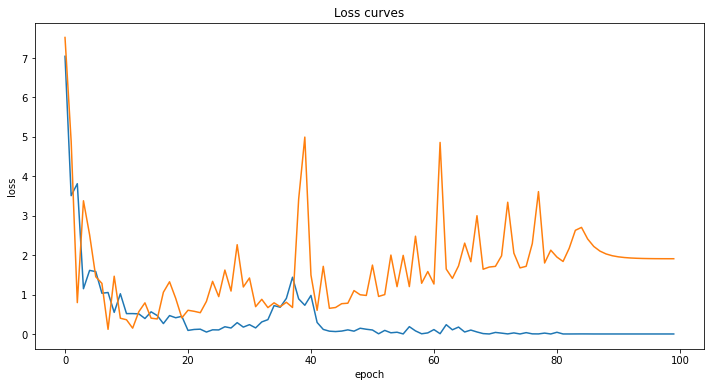

In [20]:
visualize_log(logs)

In [24]:
test(model, test_loader, device)

[[0.]] 
 [0]
[[0.]] 
 [0]
[[0.]] 
 [0]
[[1.]] 
 [0]
[[0.]] 
 [0]
[[0.]] 
 [0]
[[1.]] 
 [0]
[[0.]] 
 [0]
[[0.]] 
 [0]
[[1.]] 
 [0]


/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/d_sherki/a

0.0